In [5]:
import pandas as pd
import fairlens as fl

In [6]:
df = pd.read_csv("../datasets/compas.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20281 entries, 0 to 20280
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PersonID                 20281 non-null  int64  
 1   AssessmentID             20281 non-null  int64  
 2   CaseID                   20281 non-null  int64  
 3   Agency                   20281 non-null  object 
 4   LastName                 20281 non-null  object 
 5   FirstName                20281 non-null  object 
 6   MiddleName               5216 non-null   object 
 7   Sex                      20281 non-null  object 
 8   Ethnicity                20281 non-null  object 
 9   DateOfBirth              20281 non-null  object 
 10  ScaleSet                 20281 non-null  object 
 11  AssessmentReason         20281 non-null  object 
 12  Language                 20281 non-null  object 
 13  LegalStatus              20281 non-null  object 
 14  CustodyStatus         

In [9]:
sensitive_attributes = fl.sensitive.detect_names_df(df, deep_search=True)
print(sensitive_attributes)
print(sensitive_attributes.keys())

{'Sex': 'Gender', 'Ethnicity': 'Ethnicity', 'DateOfBirth': 'Age', 'Language': 'Nationality', 'MaritalStatus': 'Family Status'}
dict_keys(['Sex', 'Ethnicity', 'DateOfBirth', 'Language', 'MaritalStatus'])


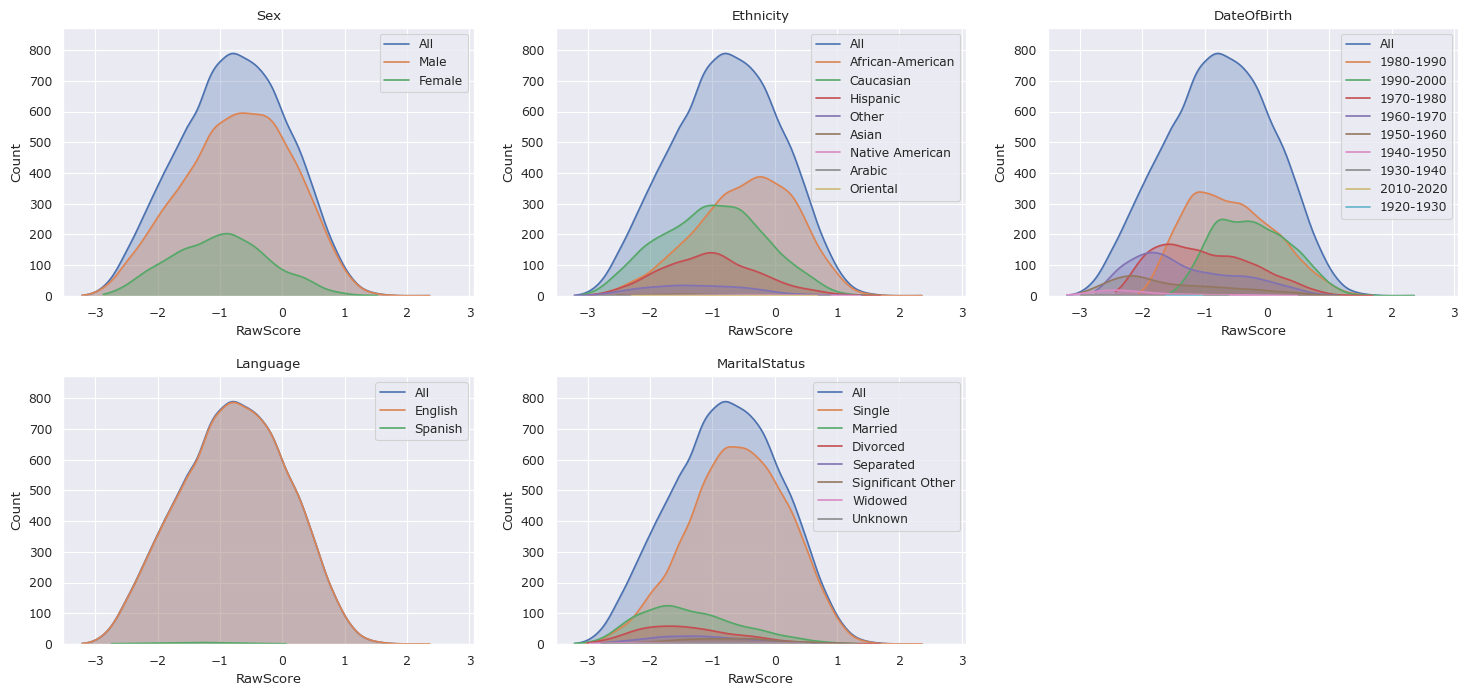

In [11]:
target_attribute = "RawScore"

fl.plot.use_style()
fl.plot.mult_distr_plot(df, target_attribute, sensitive_attributes.keys())

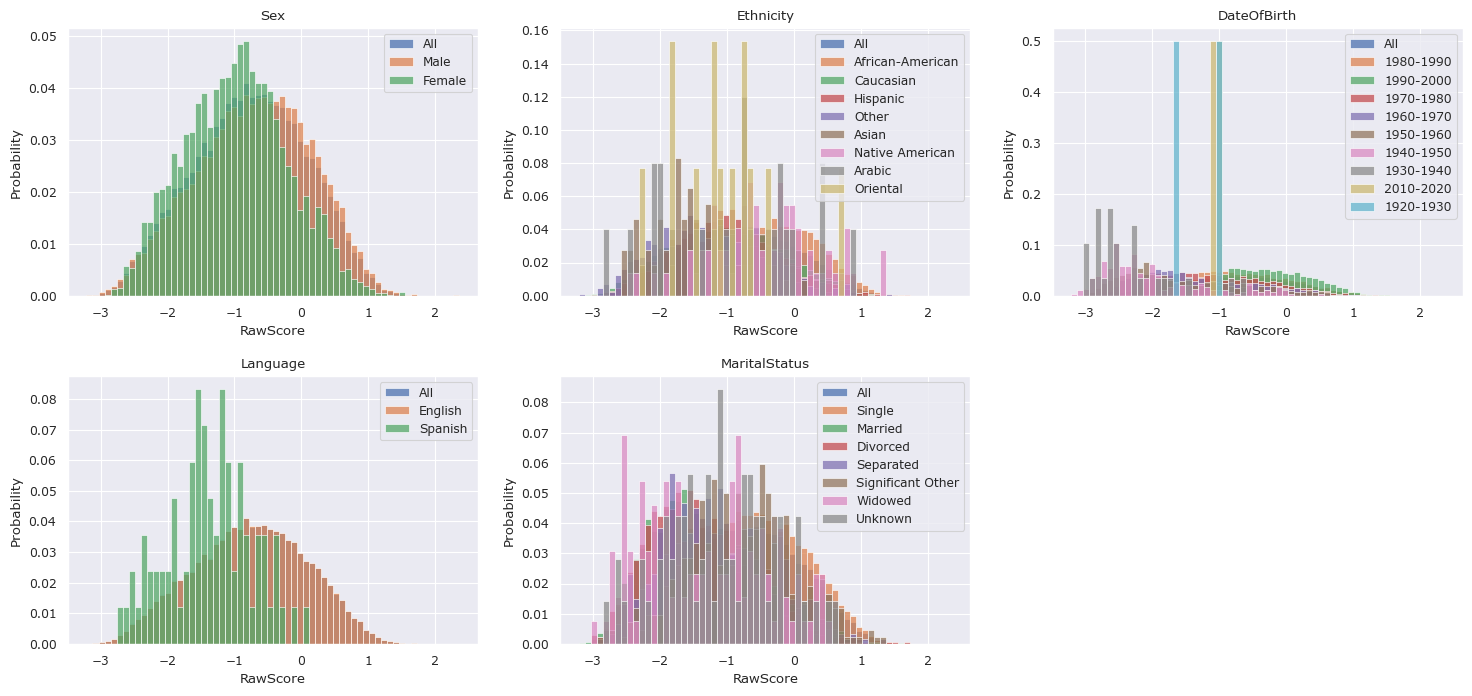

In [17]:
fl.plot.mult_distr_plot(df, target_attribute, sensitive_attributes.keys(), normalize=True, show_hist=True, show_curve=False)

<AxesSubplot:xlabel='RawScore', ylabel='Count'>

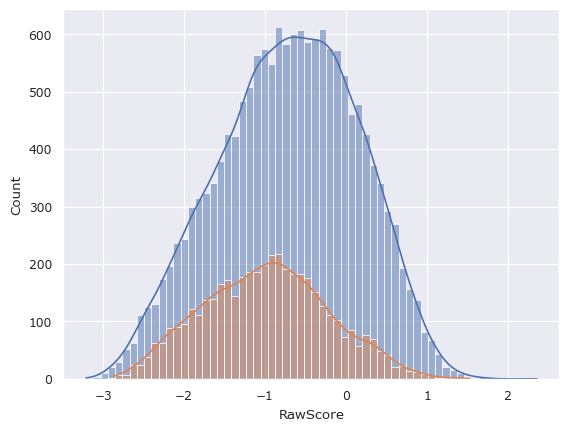

In [20]:
fl.plot.distr_plot(df, "RawScore", [{"Sex": ["Male"]}, {"Sex": ["Female"]}], show_hist=True)

<AxesSubplot:xlabel='RawScore', ylabel='Count'>

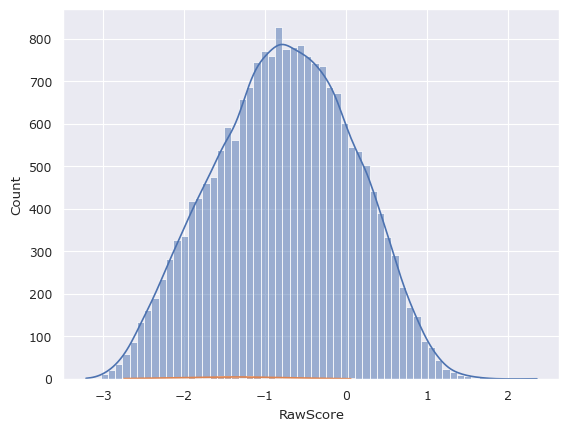

In [21]:
fl.plot.distr_plot(df, "RawScore", [{"Language": ["English"]}, {"Language": ["Spanish"]}], show_hist=True)

In [22]:
from fairlens.metrics import stat_distance

group1 = {"Sex": ["Male"]}
group2 = {"Sex": ["Female"]}
group3 = {"Language": ["English"]}
group4 = {"Language": ["Spanish"]}

target_attribute = "RawScore"

stat_distance(df, target_attribute, group1, group2, mode="auto", p_value=True)

(0.16236435605304522, 2.1425738350996494e-80)

In [23]:
distances = {}
for metric in ["mean", "emd", "ks_distance", "norm", "hellinger"]:
    try:
        dist, pval = stat_distance(df, target_attribute, group1, group2, mode=metric, p_value=True)
        distances[metric] = dist
    except Exception:
        print(metric, "failed")

pd.DataFrame.from_dict(distances, orient="index", columns=["distance"])

,distance
mean,0.272133
emd,0.274965
ks_distance,0.162364
norm,0.057039
hellinger,0.148697


In [24]:
distances = {}
for metric in ["mean", "emd", "ks_distance", "norm", "hellinger"]:
    try:
        dist, pval = stat_distance(df, target_attribute, group3, group4, mode=metric, p_value=True)
        distances[metric] = dist
    except Exception:
        print(metric, "failed")

pd.DataFrame.from_dict(distances, orient="index", columns=["distance"])

,distance
mean,0.622582
emd,0.617492
ks_distance,0.369090
norm,0.142478
hellinger,0.415647
